The following notebook performs OLS, Lasso, and Ridge regresions with a majority of the variables on charter school and traditional school seperately. 

In [125]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from matplotlib import pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.linear_model import Lasso, Ridge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import MinMaxScaler

df_combined = pd.read_csv('combined_data/combined.csv')

In [126]:
df_combined = df_combined.loc[df_combined['Charter School Dummy'] == 0]
df_combined = df_combined.dropna()
print('Number of Traditional Schools: ', df_combined.shape[0])
print(list(df_combined.columns))

Number of Traditional Schools:  7705
['School Name', 'Agency Name', 'Agency ID - NCES Assigned', 'County Name', 'County Number', 'Charter School', 'Title I School Status', 'Congressional Code', 'National School Lunch Program', 'School Level', 'Total Students All Grades (Excludes AE)', 'Free and Reduced Lunch Students', 'Male Students', 'Female Students', 'American Indian/Alaska Native Students', 'Asian or Asian/Pacific Islander Students', 'Hispanic Students', 'Black or African American Students', 'White Students', 'Nat. Hawaiian or Other Pacific Isl. Students', 'Two or More Races Students', 'School ID - NCES Assigned', 'District Entity ID', 'District Name', 'Average Percent Passing', 'Year', 'Charter School Dummy', 'Male Students Percentage', 'Female Students Percentage', 'American Indian/Alaska Native Students Percentage', 'Asian or Asian/Pacific Islander Students Percentage', 'Hispanic Students Percentage', 'Black or African American Students Percentage', 'White Students Percentage',

In [127]:
# columns to be used for analysis
X = df_combined[['Total Students All Grades (Excludes AE)', 'Free and Reduced Lunch Students Percentage', 
                'Female Students Percentage', 'American Indian/Alaska Native Students Percentage', 
                'Asian or Asian/Pacific Islander Students Percentage', 'Hispanic Students Percentage', 
                'Black or African American Students Percentage', 
                'Nat. Hawaiian or Other Pacific Isl. Students Percentage', 'Two or More Races Students Percentage', 
                '2015', '2016', '2017', '2018', '2019']]
y = df_combined[['Average Percent Passing']]

# normalizes the predictor variables
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# splits the data into training and testing
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size = 0.20)

# performs OLS regression and summarizes regression
olsReg1 = sm.OLS(y_train,X_train).fit()
print(olsReg1.summary())

# uses regression to predict with test data
y_pred = olsReg1.predict(X_test)

# compares the predicted values to the actual values to evaluate model performance
r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
print('R-squared:', r2)
print('Mean squared error:', mse)

                                   OLS Regression Results                                   
Dep. Variable:     Average Percent Passing   R-squared (uncentered):                   0.906
Model:                                 OLS   Adj. R-squared (uncentered):              0.906
Method:                      Least Squares   F-statistic:                              4244.
Date:                     Fri, 24 Mar 2023   Prob (F-statistic):                        0.00
Time:                             12:48:23   Log-Likelihood:                         -24283.
No. Observations:                     6164   AIC:                                  4.859e+04
Df Residuals:                         6150   BIC:                                  4.869e+04
Df Model:                               14                                                  
Covariance Type:                 nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025    

Best Alpha:  1e-06
MSE:  142.25067668216715


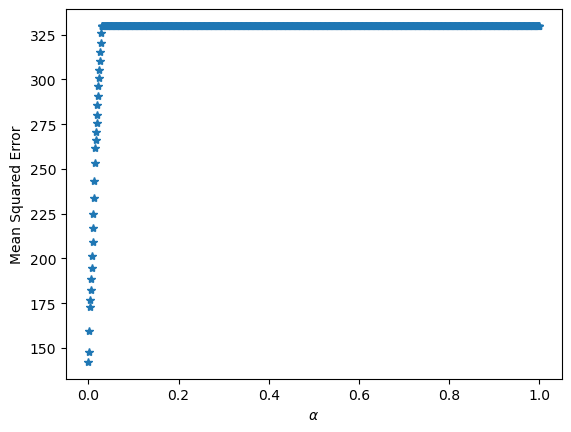

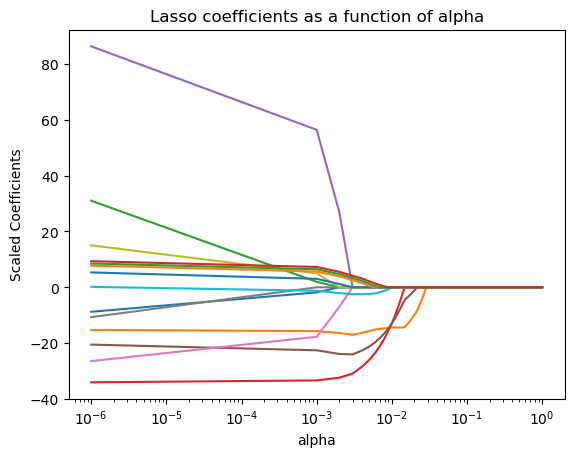

In [128]:
# constructs vector of alpha values
alphas = np.linspace(1e-6, 1, num=1000)

# constructs vectors to store mean prediction errors and coefficients
cv_errs = []
lasso_coefs = []
MSE = 500
bestalpha = 0

# loops for running ridge regression for different values of alpha
for a in alphas:
    lassoReg = make_pipeline(Lasso(alpha=a * np.sqrt(X_train.shape[0])))
    lassoReg.fit(X_train, y_train)
    y_pred = lassoReg.predict(X_test)
    cv_errs.append(mean_squared_error(y_test, y_pred))
    lasso_coefs.append(lassoReg['lasso'].coef_)
    if mean_squared_error(y_test, y_pred) < MSE: 
        MSE = mean_squared_error(y_test, y_pred)
        bestalpha = a
    
best_lasso_coefs = lasso_coefs[cv_errs.index(min(cv_errs))]

print("Best Alpha: ", bestalpha)
print("MSE: ", MSE)

# plots the MSE against the values of alphas
plt.plot(alphas, cv_errs, '*')
plt.xlabel(r'$\alpha$')
plt.ylabel('Mean Squared Error')
plt.show()

ax = plt.gca()
ax.plot(alphas, lasso_coefs)
ax.set_xscale('log')
plt.axis('tight')
plt.xlabel('alpha')
plt.ylabel('Scaled Coefficients')
plt.title('Lasso coefficients as a function of alpha');

Best Alpha:  1e-06
MSE:  142.25128696523296


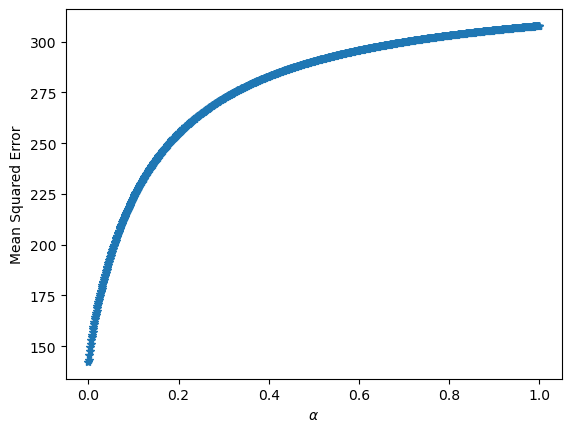

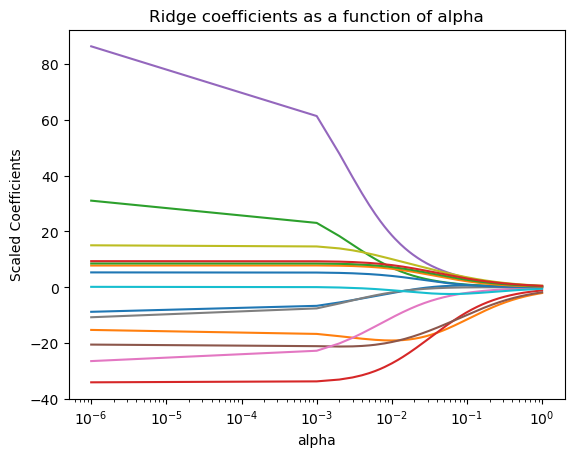

In [129]:
# constructs vector of alpha values
alphas = np.linspace(1e-6, 1, num=1000)

# constructs vectors to store mean prediction errors and coefficients
cv_errs = []
ridge_coefs = []
MSE = 500
bestalpha = 0

# loops for running ridge regression for different values of alpha
for a in alphas:
    ridgeReg = make_pipeline(Ridge(alpha=a * X_train.shape[0]))
    ridgeReg.fit(X_train, y_train)
    y_pred = ridgeReg.predict(X_test)
    cv_errs.append(mean_squared_error(y_test, y_pred))
    ridge_coefs.append(ridgeReg['ridge'].coef_)
    if mean_squared_error(y_test, y_pred) < MSE: 
        MSE = mean_squared_error(y_test, y_pred)
        bestalpha = a
    
best_ridge_coefs = ridge_coefs[cv_errs.index(min(cv_errs))]

print("Best Alpha: ", bestalpha)
print("MSE: ", MSE)

# plots the MSE against the values of alphas
plt.plot(alphas, cv_errs, '*')
plt.xlabel(r'$\alpha$')
plt.ylabel('Mean Squared Error')
plt.show()

# plots the coefficients over alpha values
ax = plt.gca()
ax.plot(alphas, np.squeeze(ridge_coefs))
ax.set_xscale('log')
plt.axis('tight')
plt.xlabel('alpha')
plt.ylabel('Scaled Coefficients')
plt.title('Ridge coefficients as a function of alpha');

In [130]:
coef_comp = pd.DataFrame({'var': X.columns.tolist(), 
                          'val_ols': olsReg1.params.tolist(),
                          'val_lasso': best_lasso_coefs,
                          'val_ridge': best_ridge_coefs[0]})
print(coef_comp)

                                                  var    val_ols  val_lasso  \
0             Total Students All Grades (Excludes AE)  -7.019991  -8.778280   
1          Free and Reduced Lunch Students Percentage -13.742510 -15.264515   
2                          Female Students Percentage  88.441135  30.986152   
3   American Indian/Alaska Native Students Percentage -30.323379 -34.020088   
4   Asian or Asian/Pacific Islander Students Perce...  90.469040  86.251093   
5                        Hispanic Students Percentage -16.688002 -20.513730   
6       Black or African American Students Percentage -25.083153 -26.422117   
7   Nat. Hawaiian or Other Pacific Isl. Students P...  -6.747428 -10.684929   
8               Two or More Races Students Percentage  26.542792  15.009094   
9                                                2015   2.825817   0.151485   
10                                               2016   7.625911   5.319755   
11                                               201

In [131]:
df_combined = pd.read_csv('combined_data/combined.csv')
df_combined = df_combined.loc[df_combined['Charter School Dummy'] == 1]
df_combined = df_combined.dropna()
print('Number of Charter Schools: ', df_combined.shape[0])

Number of Charter Schools:  2632


In [132]:
# columns to be used for analysis
X = df_combined[['Total Students All Grades (Excludes AE)', 'Free and Reduced Lunch Students Percentage', 
                'Female Students Percentage', 'American Indian/Alaska Native Students Percentage', 
                'Asian or Asian/Pacific Islander Students Percentage', 'Hispanic Students Percentage', 
                'Black or African American Students Percentage', 
                'Nat. Hawaiian or Other Pacific Isl. Students Percentage', 'Two or More Races Students Percentage',
                '2015', '2016', '2017', '2018', '2019']]
y = df_combined[['Average Percent Passing']]

# normalizes the predictor variables
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# splits the data into training and testing
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size = 0.20)

# performs OLS regression and summarizes regression
olsReg2 = sm.OLS(y_train,X_train).fit()
print(olsReg2.summary())

# uses regression to predict with test data
y_pred = olsReg2.predict(X_test)

# compares the predicted values to the actual values to evaluate model performance
r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
print('R-squared:', r2)
print('Mean squared error:', mse)

                                   OLS Regression Results                                   
Dep. Variable:     Average Percent Passing   R-squared (uncentered):                   0.887
Model:                                 OLS   Adj. R-squared (uncentered):              0.886
Method:                      Least Squares   F-statistic:                              1169.
Date:                     Fri, 24 Mar 2023   Prob (F-statistic):                        0.00
Time:                             12:48:29   Log-Likelihood:                         -8770.6
No. Observations:                     2105   AIC:                                  1.757e+04
Df Residuals:                         2091   BIC:                                  1.765e+04
Df Model:                               14                                                  
Covariance Type:                 nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025    

Best Alpha:  1e-06
MSE:  215.70995621692225


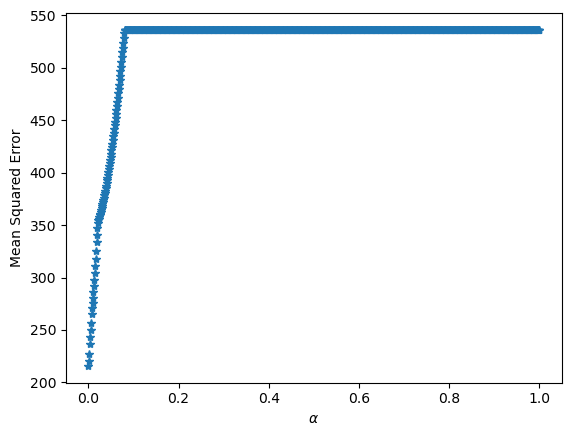

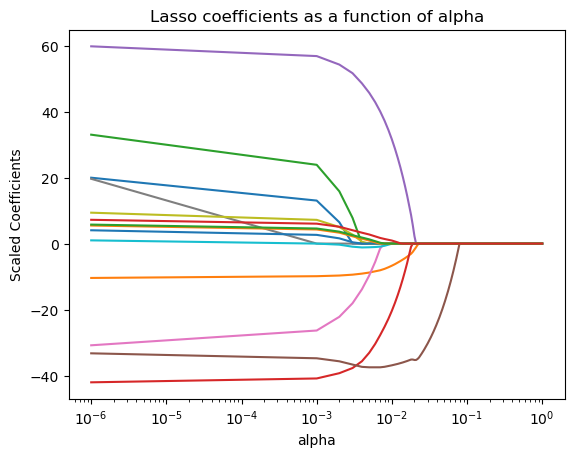

In [133]:
# constructs vector of alpha values
alphas = np.linspace(1e-6, 1, num=1000)

# constructs vectors to store mean prediction errors and coefficients
cv_errs = []
lasso_coefs = []
MSE = 500
bestalpha = 0

# loops for running ridge regression for different values of alpha
for a in alphas:
    lassoReg = make_pipeline(Lasso(alpha=a * np.sqrt(X_train.shape[0])))
    lassoReg.fit(X_train, y_train)
    y_pred = lassoReg.predict(X_test)
    cv_errs.append(mean_squared_error(y_test, y_pred))
    lasso_coefs.append(lassoReg['lasso'].coef_)
    if mean_squared_error(y_test, y_pred) < MSE: 
        MSE = mean_squared_error(y_test, y_pred)
        bestalpha = a

best_lasso_coefs = lasso_coefs[cv_errs.index(min(cv_errs))]
    
print("Best Alpha: ", bestalpha)
print("MSE: ", MSE)

# plots the MSE against the values of alphas
plt.plot(alphas, cv_errs, '*')
plt.xlabel(r'$\alpha$')
plt.ylabel('Mean Squared Error')
plt.show()

ax = plt.gca()
ax.plot(alphas, lasso_coefs)
ax.set_xscale('log')
plt.axis('tight')
plt.xlabel('alpha')
plt.ylabel('Scaled Coefficients')
plt.title('Lasso coefficients as a function of alpha');

Best Alpha:  1e-06
MSE:  215.7068255935746


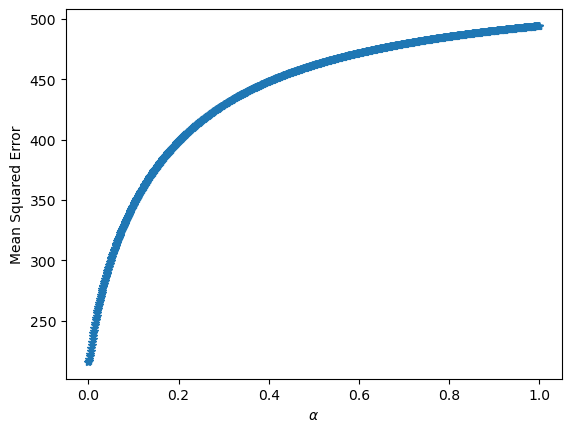

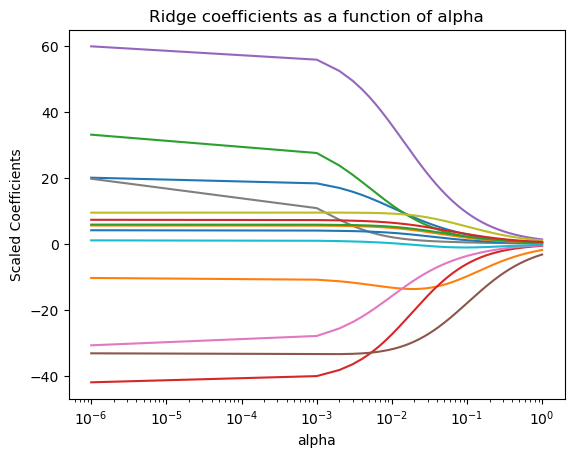

In [134]:
# constructs vector of alpha values
alphas = np.linspace(1e-6, 1, num=1000)

# constructs vectors to store mean prediction errors and coefficients
cv_errs = []
ridge_coefs = []
MSE = 500
bestalpha = 0

# loops for running ridge regression for different values of alpha
for a in alphas:
    ridgeReg = make_pipeline(Ridge(alpha=a * X_train.shape[0]))
    ridgeReg.fit(X_train, y_train)
    y_pred = ridgeReg.predict(X_test)
    cv_errs.append(mean_squared_error(y_test, y_pred))
    ridge_coefs.append(ridgeReg['ridge'].coef_)
    if mean_squared_error(y_test, y_pred) < MSE: 
        MSE = mean_squared_error(y_test, y_pred)
        bestalpha = a

best_ridge_coefs = ridge_coefs[cv_errs.index(min(cv_errs))]
    
print("Best Alpha: ", bestalpha)
print("MSE: ", MSE)

# plots the MSE against the values of alphas
plt.plot(alphas, cv_errs, '*')
plt.xlabel(r'$\alpha$')
plt.ylabel('Mean Squared Error')
plt.show()

# plots the coefficients over alpha values
ax = plt.gca()
ax.plot(alphas, np.squeeze(ridge_coefs))
ax.set_xscale('log')
plt.axis('tight')
plt.xlabel('alpha')
plt.ylabel('Scaled Coefficients')
plt.title('Ridge coefficients as a function of alpha');

In [135]:
# creates new data frame with coefficients
coef_comp = pd.DataFrame({
    'Variable': X.columns.tolist(),
    'Traditional': olsReg1.params.round(3),
    'Charter': olsReg2.params.round(3)
})

# sets index to variable name
coef_comp.set_index('Variable', inplace=True)

# formats the table for Latex
print(coef_comp.style.format("{:.3f}").to_latex())

# coef_comp = pd.DataFrame({'var': X.columns.tolist(), 
#                           'val_ols': olsReg2.params.tolist(),
#                           'val_lasso': best_lasso_coefs,
#                           'val_ridge': best_ridge_coefs[0]})
# print(coef_comp)

\begin{tabular}{lrr}
 & Traditional & Charter \\
Variable &  &  \\
Total Students All Grades (Excludes AE) & -7.020 & 24.807 \\
Free and Reduced Lunch Students Percentage & -13.743 & -7.239 \\
Female Students Percentage & 88.441 & 87.107 \\
American Indian/Alaska Native Students Percentage & -30.323 & -35.325 \\
Asian or Asian/Pacific Islander Students Percentage & 90.469 & 66.527 \\
Hispanic Students Percentage & -16.688 & -26.358 \\
Black or African American Students Percentage & -25.083 & -28.751 \\
Nat. Hawaiian or Other Pacific Isl. Students Percentage & -6.747 & 36.155 \\
Two or More Races Students Percentage & 26.543 & 20.341 \\
2015 & 2.826 & 4.668 \\
2016 & 7.626 & 7.271 \\
2017 & 9.773 & 8.302 \\
2018 & 10.498 & 8.392 \\
2019 & 11.265 & 9.933 \\
\end{tabular}

